# Imports

In [1]:
import json
import string
import numpy as np
import math

from tqdm import tqdm

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

# Metrics

In [2]:
categories = [1, 2, 3, 4]

def precision(y_true, y_pred, cat):
    return np.sum(np.logical_and(y_true == cat, y_pred == cat)) / np.sum(y_pred == cat)

def recall(y_true, y_pred, cat):
    return np.sum(np.logical_and(y_true == cat, y_pred == cat)) / np.sum(y_true == cat)

def accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

def confusion(y_true, y_pred):
    return np.array([[np.sum(np.logical_and(y_true == t, y_pred == p)) for p in categories] for t in categories])

def macro_f1(y_true, y_pred):
    macro_precision = np.mean([precision(y_true, y_pred, cat=c) for c in categories])
    macro_recall = np.mean([recall(y_true, y_pred, cat=c) for c in categories])
    return 2 * macro_precision * macro_recall / (macro_precision + macro_recall)

def evaluate(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    print('Confusion Matrix:')
    print(confusion(y_true, y_pred))
    for cat in categories:
        print('(Category %s) ---> Precision: %.3f, Recall: %.3f' %
              (cat, precision(y_true, y_pred, cat), recall(y_true, y_pred, cat)))
    print('Accuracy: ' + str(accuracy(y_true, y_pred)))
    print('Macro F1: ' + str(macro_f1(y_true, y_pred)))

# Data Preparation

## Read the data

In [3]:
with open('data/train.json', 'r') as f:
    train_data = json.loads(f.read())
with open('data/validation.json', 'r') as f:
    val_data = json.loads(f.read())
len(train_data), len(val_data)

(24000, 3000)

## tf-idf

In [4]:
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))
len(stopwords)

[nltk_data] Downloading package stopwords to /Users/air/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


179

In [5]:
stemmer = PorterStemmer()

nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /Users/air/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
def remove_punc(s):
    return s.translate(str.maketrans('', '', string.punctuation))

def clean_up(text, mode=None):
    # mode can be 'stemming', 'lemmatization', 'stopword-removal' or None
    
    words = remove_punc(text.lower()).split()
    
    if mode is None:
        return words
    elif mode == 'stemming':
        return [stemmer.stem(word) for word in words]
    elif mode == 'lemmatization':
        return [lemmatizer.lemmatize(word) for word in words]
    elif mode == 'stopword-removal':
        return [word for word in words if word not in stopwords]

def tokenize_news(news, title_weight=1, clean_up_mode=None):
    return clean_up(news['body'], mode=clean_up_mode) + title_weight * clean_up(news['title'], mode=clean_up_mode)

In [7]:
class TFIDF:
    def __init__(self, clean_up_mode=None):
        self.index = None
        self.dict = None
        self.news_count = -1
        self.clean_up_mode = clean_up_mode
    
    def _append_to_index(self, index, news_tokens, news_id, allow_new_words=True):
        for word in news_tokens:
            if word not in index:
                if not allow_new_words:
                    continue
                index[word] = {}
            node = index[word]
            if news_id not in node:
                node[news_id] = 0
            node[news_id] += 1

    def _create_index(self, data):
        index = {}
        for news_id, news in enumerate(data):
            self._append_to_index(index, tokenize_news(news, clean_up_mode=self.clean_up_mode), news_id)
        return index

    def fit(self, data):
        self.index = self._create_index(data)
        self.dict = list(self.index.keys())
        self.news_count = len(data)

    def _idf(self, word):    
        df = len(self.index[word])
        idf = math.log10(self.news_count / df)
        return idf
        
    def _transform(self, data):
        vectors = []
        for news_id, news in tqdm(enumerate(data), total=len(data)):
            vector = np.zeros(len(self.dict))
            
            words, counts = np.unique(
                tokenize_news(news, clean_up_mode=self.clean_up_mode), 
                return_counts=True
            )
            
            for word, count in zip(words, counts):
                if word not in self.dict:
                    continue
                word_index = self.dict.index(word)
                tf = count
                idf = self._idf(word)
                vector[word_index] = tf * idf
            vectors.append(vector)
        return vectors

    def transform(self, data):
        if self.index is None:
            raise RuntimeError('Please call fit() first.')
        return self._transform(data)

    def fit_transform(self, data):
        self.fit(data)
        return self._transform(data)

In [8]:
tfidf = TFIDF()
train_vectors = tfidf.fit_transform(train_data)
val_vectors = tfidf.transform(val_data)
len(train_vectors), len(val_vectors)

100%|██████████| 3000/3000 [00:18<00:00, 161.03it/s]


(24000, 3000)

In [9]:
X_train = np.array(train_vectors)
y_train = np.array([news['category'] for news in train_data])

X_val = np.array(val_vectors)
y_val = np.array([news['category'] for news in val_data])

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((24000, 46490), (24000,), (3000, 46490), (3000,))

# KNN

In [10]:
class KNN:
    def __init__(self, k, mode='euclidean-distance'):
        # mode can be one of one of 'cosine-similarity' and 'euclidean-distance'
        self.k = k
        self.mode = mode
        self.T = None
        self.norms = None
        self.y = None
    
    def fit(self, T, y):
        self.T = T
        if self.mode == 'cosine-similarity':
            self.T = self.T / np.linalg.norm(T, axis=1, keepdims=True)
        elif self.mode == 'euclidean-distance':
            self.T2 = np.sum(self.T ** 2, axis=1, keepdims=True)
        self.y = y
    
    def predict(self, V):
        if self.mode == 'cosine-similarity':
            Vnorms = np.linalg.norm(V, axis=1, keepdims=True)
            D = 1 - np.matmul(self.T, (V / Vnorms).T)
        elif self.mode == 'euclidean-distance':
            V2 = np.sum(V ** 2, axis=1, keepdims=True)
            D = self.T2 - 2 * np.matmul(self.T, V.T) + V2.T
        
        bests = np.argsort(D, axis=0)[:self.k, :]
        best_labels = self.y[bests]
        return np.array([np.bincount(best_labels[:, i]).argmax() for i in range(best_labels.shape[1])])

In [11]:
def eval_knn(k, mode, X_train, y_train, X_val, y_val):
    knn = KNN(k=k, mode=mode)
    knn.fit(X_train, y_train)
    p_val = knn.predict(X_val)
    evaluate(y_val, p_val)

In [38]:
for k in [1, 3, 5]:
    for mode in ['euclidean-distance', 'cosine-similarity']:
        print('KNN (k={}, mode={})'.format(k, mode))
        eval_knn(k, mode, X_train, y_train, X_val, y_val)
        print('_' * 100)

KNN (k=1, mode=euclidean-distance)
Confusion Matrix:
[[370  12 357  11]
 [ 43 275 425   7]
 [ 24   2 677  47]
 [ 21   3 383 343]]
(Category 1) ---> Precision: 0.808, Recall: 0.493
(Category 2) ---> Precision: 0.942, Recall: 0.367
(Category 3) ---> Precision: 0.368, Recall: 0.903
(Category 4) ---> Precision: 0.841, Recall: 0.457
Accuracy: 0.555
Macro F1: 0.6340893456638655
____________________________________________________________________________________________________
KNN (k=1, mode=cosine-similarity)
Confusion Matrix:
[[637  37  43  33]
 [ 38 679  18  15]
 [ 53  12 612  73]
 [ 35  21  85 609]]
(Category 1) ---> Precision: 0.835, Recall: 0.849
(Category 2) ---> Precision: 0.907, Recall: 0.905
(Category 3) ---> Precision: 0.807, Recall: 0.816
(Category 4) ---> Precision: 0.834, Recall: 0.812
Accuracy: 0.8456666666666667
Macro F1: 0.8457131907155844
____________________________________________________________________________________________________
KNN (k=3, mode=euclidean-distance)
C

According the previous cell, the best result was achieved by `k=5` and `cosine-similarity`.

# Naive Bayes

In [12]:
class NaiveBayes:
    def __init__(self, alpha, clean_up_mode=None):
        self.alpha = alpha
        self.clean_up_mode = clean_up_mode
        
        self.index = None
        self.cats = None
        self.log_Ptc = None
        self.log_Pc = None
    
    def _fill_Pc(self):
        ucats, counts = np.unique(self.cats, return_counts=True)
        Pc = {cat: count / len(self.cats) for cat, count in zip(ucats, counts)}
        self.log_Pc = {c: math.log(Pc[c]) for c in Pc}
        
    def _fill_Ptc(self, data):
        Ttc = {t: {c: 0 for c in categories} for t in self.index}
        Ttc_sums = {c: 0 for c in categories}
        for t in self.index:
            term_node = self.index[t]    
            for news_id in term_node:
                occurance = term_node[news_id]
                cat = self.cats[news_id]
                Ttc[t][cat] += occurance
                Ttc_sums[cat] += occurance
        
        dict_size = len(self.index)
        log_Ttc_sums = {c: math.log(Ttc_sums[c] + dict_size * self.alpha) for c in Ttc_sums}
        self.log_Ptc = {t: {c: math.log(Ttc[t][c] + self.alpha) - log_Ttc_sums[c] for c in categories} for t in self.index}

    def _init_index(self, data):
        tfidf = TFIDF(clean_up_mode=self.clean_up_mode)
        tfidf.fit(data)
        self.index = tfidf.index
    
    def fit(self, data):
        self.cats = [news['category'] for news in data]
        self._init_index(data)
        self._fill_Pc()
        self._fill_Ptc(data)
    
    def _predict_single_news(self, news):
        terms = tokenize_news(news, clean_up_mode=self.clean_up_mode)
        log_probs = {c: self.log_Pc[c] + sum([self.log_Ptc[t][c] for t in terms if t in self.index]) for c in categories}
        return max(log_probs, key=log_probs.get)
        
    def predict(self, data):
        return np.array([self._predict_single_news(news) for news in data])

## Finding the best `alpha`

In [28]:
def eval_naive(alpha, clean_up_mode=None):
    naive = NaiveBayes(alpha, clean_up_mode=clean_up_mode)
    naive.fit(train_data)
    evaluate(y_val, naive.predict(val_data))

In [29]:
for alpha in [1e-1, 1e0, 1e1]:
    print('Naive Bayes (alpha: {})'.format(alpha))
    eval_naive(alpha)
    print('_' * 100)

Naive Bayes (alpha: 0.1)
Confusion Matrix:
[[658  29  31  32]
 [ 11 732   3   4]
 [ 28  10 635  77]
 [ 26   8  55 661]]
(Category 1) ---> Precision: 0.910, Recall: 0.877
(Category 2) ---> Precision: 0.940, Recall: 0.976
(Category 3) ---> Precision: 0.877, Recall: 0.847
(Category 4) ---> Precision: 0.854, Recall: 0.881
Accuracy: 0.8953333333333333
Macro F1: 0.8952716685125364
____________________________________________________________________________________________________
Naive Bayes (alpha: 1.0)
Confusion Matrix:
[[664  29  29  28]
 [  9 734   2   5]
 [ 27   9 640  74]
 [ 32   9  58 651]]
(Category 1) ---> Precision: 0.907, Recall: 0.885
(Category 2) ---> Precision: 0.940, Recall: 0.979
(Category 3) ---> Precision: 0.878, Recall: 0.853
(Category 4) ---> Precision: 0.859, Recall: 0.868
Accuracy: 0.8963333333333333
Macro F1: 0.8961264401591561
____________________________________________________________________________________________________
Naive Bayes (alpha: 10.0)
Confusion Matrix

Among these three, `alpha` the best would be `1`. (Actually if you test `1.3` it's gonna be better!)

# Text Preprocessing

In [22]:
def eval_text_preprocessing_method(method):
    print("Text Preprocessing ({})".format(method))
    
    # knn
    tfidf = TFIDF(clean_up_mode=method)
    train_vectors = tfidf.fit_transform(train_data)
    val_vectors = tfidf.transform(val_data)
    
    X_train = np.array(train_vectors)
    y_train = np.array([news['category'] for news in train_data])

    X_val = np.array(val_vectors)
    y_val = np.array([news['category'] for news in val_data])
    
    eval_knn(3, 'cosine-similarity', X_train, y_train, X_val, y_val)
    print('_' * 100)
    
    # naive bayes
    print('Naive Bayes (alpha: 1)')
    eval_naive(1, clean_up_mode=method)

In [23]:
for method in ['stemming', 'lemmatization', 'stopword-removal']:
    eval_text_preprocessing_method(method)
    print('*' * 100)

Text Preprocessing (stemming)


100%|██████████| 3000/3000 [00:16<00:00, 184.05it/s]


Confusion Matrix:
[[650  27  45  28]
 [ 24 700  16  10]
 [ 55  12 613  70]
 [ 40  22  60 628]]
(Category 1) ---> Precision: 0.845, Recall: 0.867
(Category 2) ---> Precision: 0.920, Recall: 0.933
(Category 3) ---> Precision: 0.835, Recall: 0.817
(Category 4) ---> Precision: 0.853, Recall: 0.837
Accuracy: 0.8636666666666667
Macro F1: 0.8635216367515741
____________________________________________________________________________________________________
Naive Bayes (alpha: 1)
Confusion Matrix:
[[669  27  31  23]
 [  9 733   2   6]
 [ 26  11 636  77]
 [ 31  12  57 650]]
(Category 1) ---> Precision: 0.910, Recall: 0.892
(Category 2) ---> Precision: 0.936, Recall: 0.977
(Category 3) ---> Precision: 0.876, Recall: 0.848
(Category 4) ---> Precision: 0.860, Recall: 0.867
Accuracy: 0.896
Macro F1: 0.8957710088495209
____________________________________________________________________________________________________
**********************************************************************************

100%|██████████| 3000/3000 [00:20<00:00, 147.47it/s]


Confusion Matrix:
[[654  27  43  26]
 [ 26 701  11  12]
 [ 58  15 609  68]
 [ 40  21  59 630]]
(Category 1) ---> Precision: 0.841, Recall: 0.872
(Category 2) ---> Precision: 0.918, Recall: 0.935
(Category 3) ---> Precision: 0.843, Recall: 0.812
(Category 4) ---> Precision: 0.856, Recall: 0.840
Accuracy: 0.8646666666666667
Macro F1: 0.8645364136119422
____________________________________________________________________________________________________
Naive Bayes (alpha: 1)
Confusion Matrix:
[[670  29  30  21]
 [  8 736   1   5]
 [ 28  10 637  75]
 [ 31  11  58 650]]
(Category 1) ---> Precision: 0.909, Recall: 0.893
(Category 2) ---> Precision: 0.936, Recall: 0.981
(Category 3) ---> Precision: 0.877, Recall: 0.849
(Category 4) ---> Precision: 0.866, Recall: 0.867
Accuracy: 0.8976666666666666
Macro F1: 0.897383343395837
____________________________________________________________________________________________________
**********************************************************************

100%|██████████| 3000/3000 [00:22<00:00, 134.81it/s]


Confusion Matrix:
[[646  33  42  29]
 [ 25 703  10  12]
 [ 55  19 605  71]
 [ 53  19  56 622]]
(Category 1) ---> Precision: 0.829, Recall: 0.861
(Category 2) ---> Precision: 0.908, Recall: 0.937
(Category 3) ---> Precision: 0.849, Recall: 0.807
(Category 4) ---> Precision: 0.847, Recall: 0.829
Accuracy: 0.8586666666666667
Macro F1: 0.8585177850115814
____________________________________________________________________________________________________
Naive Bayes (alpha: 1)
Confusion Matrix:
[[666  26  33  25]
 [  8 735   1   6]
 [ 26  10 643  71]
 [ 32  10  58 650]]
(Category 1) ---> Precision: 0.910, Recall: 0.888
(Category 2) ---> Precision: 0.941, Recall: 0.980
(Category 3) ---> Precision: 0.875, Recall: 0.857
(Category 4) ---> Precision: 0.864, Recall: 0.867
Accuracy: 0.898
Macro F1: 0.8977660455694932
____________________________________________________________________________________________________
**********************************************************************************

KNN worked better without any text preprocessing But Naive Bayes worked a little better with lemmatization and stopword removal.

# SVM

In [77]:
from sklearn.svm import SVC

def eval_svm(C, X_train, y_train, X_val, y_val):
    svm = SVC(C=C, kernel='linear', verbose=True, random_state=10)
    svm.fit(X_train[:1000], y_train[:1000])
    evaluate(y_val[:1000], svm.predict(X_val[:1000]))

In [78]:
for C in [1e-1, 1e0, 1e1]:
    print('SVM (C: {})'.format(C))
    eval_svm(C, X_train, y_train, X_val, y_val)
    print('_' * 100)

SVM (C: 0.1)
[LibSVM]Confusion Matrix:
[[205  12  15  22]
 [  9 220   0  14]
 [  9   4 193  57]
 [ 11  15  17 197]]
(Category 1) ---> Precision: 0.876, Recall: 0.807
(Category 2) ---> Precision: 0.876, Recall: 0.905
(Category 3) ---> Precision: 0.858, Recall: 0.734
(Category 4) ---> Precision: 0.679, Recall: 0.821
Accuracy: 0.815
Macro F1: 0.8195853850093838
____________________________________________________________________________________________________
SVM (C: 1.0)
[LibSVM]Confusion Matrix:
[[205  12  15  22]
 [  9 220   0  14]
 [  9   4 193  57]
 [ 11  15  17 197]]
(Category 1) ---> Precision: 0.876, Recall: 0.807
(Category 2) ---> Precision: 0.876, Recall: 0.905
(Category 3) ---> Precision: 0.858, Recall: 0.734
(Category 4) ---> Precision: 0.679, Recall: 0.821
Accuracy: 0.815
Macro F1: 0.8195853850093838
____________________________________________________________________________________________________
SVM (C: 10.0)
[LibSVM]Confusion Matrix:
[[205  12  15  22]
 [  9 220   0  14

There does not seem to be any difference in the `C` values that we tested.

We also used only `1000` samples because more samples would need much time to run.

# Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier

def eval_rf(n_estimators, max_depth, X_train, y_train, X_val, y_val):
    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, verbose=True, random_state=10)
    rf.fit(X_train, y_train)
    evaluate(y_val, rf.predict(X_val))

In [27]:
for n_estimators in [50, 100, 200]:
    for max_depth in [2, 3, 4]:
        print('Random Forest (n_estimators: {}, max_depth: {})'.format(n_estimators, max_depth))
        eval_rf(n_estimators, max_depth, X_train, y_train, X_val, y_val)
        print('_' * 100)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   25.9s finished


Random Forest (n_estimators: 50, max_depth: 2)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


Confusion Matrix:
[[365 161  72 152]
 [ 10 594  28 118]
 [ 24 113 433 180]
 [ 24 150 124 452]]
(Category 1) ---> Precision: 0.863, Recall: 0.487
(Category 2) ---> Precision: 0.583, Recall: 0.792
(Category 3) ---> Precision: 0.659, Recall: 0.577
(Category 4) ---> Precision: 0.501, Recall: 0.603
Accuracy: 0.6146666666666667
Macro F1: 0.6326119355019532
____________________________________________________________________________________________________


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   31.0s finished


Random Forest (n_estimators: 50, max_depth: 3)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


Confusion Matrix:
[[422 146  49 133]
 [ 18 626  14  92]
 [ 29  90 462 169]
 [ 24 108  96 522]]
(Category 1) ---> Precision: 0.856, Recall: 0.563
(Category 2) ---> Precision: 0.645, Recall: 0.835
(Category 3) ---> Precision: 0.744, Recall: 0.616
(Category 4) ---> Precision: 0.570, Recall: 0.696
Accuracy: 0.6773333333333333
Macro F1: 0.6903100633135753
____________________________________________________________________________________________________


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   44.4s finished


Random Forest (n_estimators: 50, max_depth: 4)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


Confusion Matrix:
[[467 124  51 108]
 [ 10 659  17  64]
 [ 26  81 482 161]
 [ 25  90  87 548]]
(Category 1) ---> Precision: 0.884, Recall: 0.623
(Category 2) ---> Precision: 0.691, Recall: 0.879
(Category 3) ---> Precision: 0.757, Recall: 0.643
(Category 4) ---> Precision: 0.622, Recall: 0.731
Accuracy: 0.7186666666666667
Macro F1: 0.7284407827679705
____________________________________________________________________________________________________


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   41.5s finished


Random Forest (n_estimators: 100, max_depth: 2)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Confusion Matrix:
[[489 111  56  94]
 [ 20 637  15  78]
 [ 42  78 468 162]
 [ 47 113 100 490]]
(Category 1) ---> Precision: 0.818, Recall: 0.652
(Category 2) ---> Precision: 0.678, Recall: 0.849
(Category 3) ---> Precision: 0.732, Recall: 0.624
(Category 4) ---> Precision: 0.595, Recall: 0.653
Accuracy: 0.6946666666666667
Macro F1: 0.700184352064509
____________________________________________________________________________________________________


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   43.8s finished


Random Forest (n_estimators: 100, max_depth: 3)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


Confusion Matrix:
[[518  85  49  98]
 [ 11 647  12  80]
 [ 33  59 486 172]
 [ 36  72  89 553]]
(Category 1) ---> Precision: 0.866, Recall: 0.691
(Category 2) ---> Precision: 0.750, Recall: 0.863
(Category 3) ---> Precision: 0.764, Recall: 0.648
(Category 4) ---> Precision: 0.612, Recall: 0.737
Accuracy: 0.7346666666666667
Macro F1: 0.7413329273442321
____________________________________________________________________________________________________


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.0min finished


Random Forest (n_estimators: 100, max_depth: 4)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


Confusion Matrix:
[[549  89  45  67]
 [ 12 690  10  38]
 [ 31  59 507 153]
 [ 34  76  69 571]]
(Category 1) ---> Precision: 0.877, Recall: 0.732
(Category 2) ---> Precision: 0.755, Recall: 0.920
(Category 3) ---> Precision: 0.803, Recall: 0.676
(Category 4) ---> Precision: 0.689, Recall: 0.761
Accuracy: 0.7723333333333333
Macro F1: 0.7766657780716474
____________________________________________________________________________________________________


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  1.4min finished


Random Forest (n_estimators: 200, max_depth: 2)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


Confusion Matrix:
[[559  89  32  70]
 [ 12 691   9  38]
 [ 46  54 514 136]
 [ 43  71 102 534]]
(Category 1) ---> Precision: 0.847, Recall: 0.745
(Category 2) ---> Precision: 0.764, Recall: 0.921
(Category 3) ---> Precision: 0.782, Recall: 0.685
(Category 4) ---> Precision: 0.686, Recall: 0.712
Accuracy: 0.766
Macro F1: 0.767898398176686
____________________________________________________________________________________________________


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  1.5min finished


Random Forest (n_estimators: 200, max_depth: 3)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


Confusion Matrix:
[[577  75  34  64]
 [  8 698   5  39]
 [ 43  51 515 141]
 [ 39  65  94 552]]
(Category 1) ---> Precision: 0.865, Recall: 0.769
(Category 2) ---> Precision: 0.785, Recall: 0.931
(Category 3) ---> Precision: 0.795, Recall: 0.687
(Category 4) ---> Precision: 0.693, Recall: 0.736
Accuracy: 0.7806666666666666
Macro F1: 0.7826333345330319
____________________________________________________________________________________________________


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.0min finished


Random Forest (n_estimators: 200, max_depth: 4)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


Confusion Matrix:
[[592  77  34  47]
 [ 12 712   5  21]
 [ 46  47 534 123]
 [ 38  70  78 564]]
(Category 1) ---> Precision: 0.860, Recall: 0.789
(Category 2) ---> Precision: 0.786, Recall: 0.949
(Category 3) ---> Precision: 0.820, Recall: 0.712
(Category 4) ---> Precision: 0.747, Recall: 0.752
Accuracy: 0.8006666666666666
Macro F1: 0.8020351710480332
____________________________________________________________________________________________________


Among the values we tested, `n_estimators=200` and `max_depth=4` were the best. But probably bigger values are going to have better results.

# K-means

In [15]:
def distance(T, V, mode='euclidean-distance'):
    if mode == 'cosine-similarity':
        Vnorms = np.linalg.norm(V, axis=1, keepdims=True)
        Tnorms = np.linalg.norm(T, axis=1, keepdims=True)
        return 1 - np.matmul(T / Tnorms, (V / Vnorms).T)
    elif mode == 'euclidean-distance':
        V2 = np.sum(V ** 2, axis=1, keepdims=True)
        T2 = np.sum(T ** 2, axis=1, keepdims=True)
        return T2 - 2 * np.matmul(T, V.T) + V2.T

class KMeans:
    def __init__(self, k, mode='euclidean-distance'):
        self.k = k
        self.mode = mode
        
    
    def _init_centroids(self, X):
        centroids_index = np.random.choice(len(X), size=self.k, replace=False)
        return X[centroids_index]
    
    def cluster(self, X, max_iter=10000):
        centroids = self._init_centroids(X)
        
        for iteration in range(max_iter):
            distances = distance(centroids, X, mode=self.mode)
            xclusters = np.argmin(distances, axis=0)
            next_centroids = np.array([np.mean(X[xclusters == c], axis=0) for c in range(self.k)])
            if np.sum(centroids != next_centroids) == 0:
                break
            centroids = next_centroids
        return xclusters

In [68]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def cluster_to_color(cluster):
    if cluster == 0:
        return 'r'
    if cluster == 1:
        return 'g'
    if cluster == 2:
        return 'b'
    if cluster == 3:
        return 'y'

def kmean_tsne(vectors, labels):
    X_embedded = TSNE(n_components=2).fit_transform(vectors)

    kmeans = KMeans(k=len(categories), mode='cosine-similarity')
    clusters = kmeans.cluster(vectors)

    for x, c in zip(X_embedded, clusters):
        plt.plot([x[0]], [x[1]], 'o', color=cluster_to_color(c))
    plt.show()

    for c in categories:
        uniques, counts = np.unique(clusters[labels == c], return_counts=True)
        print('Distribution of news of category {} in clusters: {} -> {}'.format(c, uniques, counts))

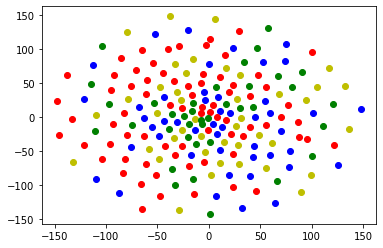

Distribution of news of category 1 in clusters: [0 1 2 3] -> [13 10 11 17]
Distribution of news of category 2 in clusters: [0 1 2 3] -> [19  6 10 13]
Distribution of news of category 3 in clusters: [0 1 2 3] -> [24 11 11  2]
Distribution of news of category 4 in clusters: [0 1 2 3] -> [18 10 15 10]


In [69]:
kmean_tsne(X_train[:200], y_train[:200])

We can't see the clusters in the 2D representation that tsne has found for our data.
Also according to the previous cell seems like the 4 clusters are not the same as our 4 categories.

Note that `mode='cosine-similarity'` is used because `euclidian-distance` does not work well here and classifies all the samples in the same cluster. But if we normalize the vectors first we probably won't face this problem.

# Word2Vec

In [74]:
from gensim.models import Word2Vec

def idf(term):
    if term not in tfidf.index:
        return 0
    return tfidf._idf(term)

def news_to_vector(news_tokens, word_vectors):
    idfs = {term: idf(term) for term in news_tokens if term in word_vectors}
    terms_vectors = np.array([word_vectors[term] * idfs[term] for term in news_tokens if term in word_vectors])
    return np.sum(terms_vectors, axis=0) / sum(idfs.values())

#     terms_vectors = np.array([word_vectors[term] for term in news_tokens if term in word_vectors])
#     return np.mean(terms_vectors, axis=0)

In [75]:
def eval_word2vec(window_size, latent_dim):
    tokenized_news = [tokenize_news(news) for news in train_data]
    word_vectors = Word2Vec(
        sentences=tokenized_news,
        window=window_size,
        size=latent_dim
    ).wv
    
    news_vectors = [news_to_vector(news, word_vectors) for news in tokenized_news]
    vectors = np.array(news_vectors[:200])
    
    print('Word2Vec with window={} and latent_dim={}'.format(window_size, latent_dim))
    kmean_tsne(vectors, y_train[:200])
    print('_' * 100)

Word2Vec with window=3 and latent_dim=50


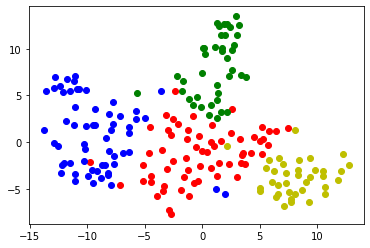

Distribution of news of category 1 in clusters: [0 1 2 3] -> [10 37  2  2]
Distribution of news of category 2 in clusters: [0 3] -> [16 32]
Distribution of news of category 3 in clusters: [0 1 2 3] -> [12  2 33  1]
Distribution of news of category 4 in clusters: [0 1 2 3] -> [25  1 25  2]
____________________________________________________________________________________________________
Word2Vec with window=3 and latent_dim=100


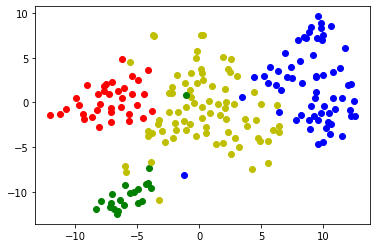

Distribution of news of category 1 in clusters: [0 1 2 3] -> [ 2 21  1 27]
Distribution of news of category 2 in clusters: [0 3] -> [31 17]
Distribution of news of category 3 in clusters: [0 2 3] -> [ 1 34 13]
Distribution of news of category 4 in clusters: [0 2 3] -> [ 2 28 23]
____________________________________________________________________________________________________
Word2Vec with window=3 and latent_dim=200


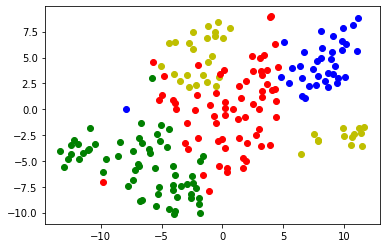

Distribution of news of category 1 in clusters: [0 1 2 3] -> [13  2  2 34]
Distribution of news of category 2 in clusters: [0 2] -> [17 31]
Distribution of news of category 3 in clusters: [0 1 2 3] -> [12 33  1  2]
Distribution of news of category 4 in clusters: [0 1 2 3] -> [25 25  2  1]
____________________________________________________________________________________________________
Word2Vec with window=5 and latent_dim=50


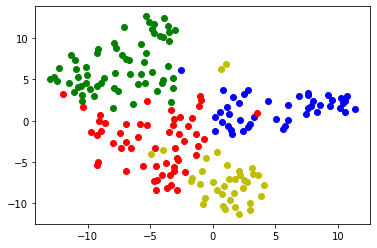

Distribution of news of category 1 in clusters: [0 1 2 3] -> [ 8  1 40  2]
Distribution of news of category 2 in clusters: [0 3] -> [16 32]
Distribution of news of category 3 in clusters: [0 1 2 3] -> [10 35  2  1]
Distribution of news of category 4 in clusters: [0 1 2 3] -> [22 26  3  2]
____________________________________________________________________________________________________
Word2Vec with window=5 and latent_dim=100


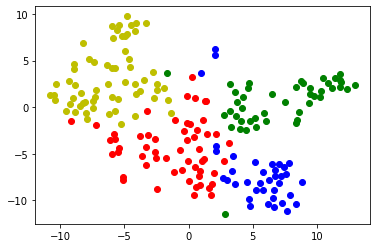

Distribution of news of category 1 in clusters: [0 1 2 3] -> [ 8 40  2  1]
Distribution of news of category 2 in clusters: [0 2] -> [16 32]
Distribution of news of category 3 in clusters: [0 1 2 3] -> [10  2  1 35]
Distribution of news of category 4 in clusters: [0 1 2 3] -> [22  3  2 26]
____________________________________________________________________________________________________
Word2Vec with window=5 and latent_dim=200


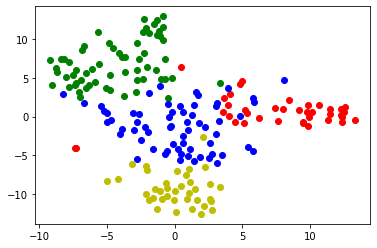

Distribution of news of category 1 in clusters: [0 1 2 3] -> [36  2 11  2]
Distribution of news of category 2 in clusters: [2 3] -> [16 32]
Distribution of news of category 3 in clusters: [0 1 2 3] -> [ 2 34 11  1]
Distribution of news of category 4 in clusters: [1 2 3] -> [26 25  2]
____________________________________________________________________________________________________
Word2Vec with window=7 and latent_dim=50


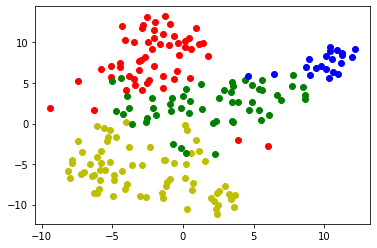

Distribution of news of category 1 in clusters: [0 1 2 3] -> [ 2 26 21  2]
Distribution of news of category 2 in clusters: [0 1] -> [46  2]
Distribution of news of category 3 in clusters: [0 1 3] -> [ 1 13 34]
Distribution of news of category 4 in clusters: [0 1 3] -> [ 5 13 35]
____________________________________________________________________________________________________
Word2Vec with window=7 and latent_dim=100


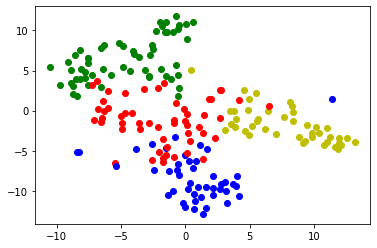

Distribution of news of category 1 in clusters: [0 1 2 3] -> [ 8  1  2 40]
Distribution of news of category 2 in clusters: [0 2] -> [ 9 39]
Distribution of news of category 3 in clusters: [0 1 2 3] -> [12 33  1  2]
Distribution of news of category 4 in clusters: [0 1 2 3] -> [25 24  3  1]
____________________________________________________________________________________________________
Word2Vec with window=7 and latent_dim=200


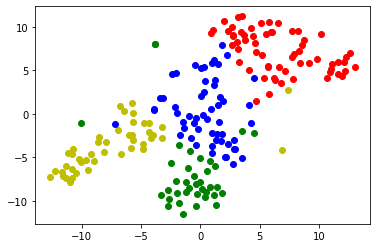

Distribution of news of category 1 in clusters: [0 1 2 3] -> [ 1  2  8 40]
Distribution of news of category 2 in clusters: [1 2] -> [32 16]
Distribution of news of category 3 in clusters: [0 1 2 3] -> [35  1 10  2]
Distribution of news of category 4 in clusters: [0 1 2 3] -> [26  2 22  3]
____________________________________________________________________________________________________


In [76]:
for window in [3, 5, 7]:
    for laten_dim in [50, 100, 200]:
        eval_word2vec(window, laten_dim)

The results of word2vec is signifanctly improved in comparision to tdidf.
Category 1 and 2 are seperated better than the other two.

It's also notable that to construct a vector for each doc we took a weighted average of the vectors of it's terms. The weights were `idf` of terms.